In [86]:
import os
import sys
import math
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime

# Matplotlib style
plt.style.use("seaborn-v0_8-whitegrid")

# -----------------------------
# Paths (portable)
# -----------------------------
PROJECT_ROOT = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path(".").resolve()

OUTPUT_DIR = PROJECT_ROOT / "outputs"
FIG_DIR = OUTPUT_DIR / "figures"
for p in [OUTPUT_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

def find_data_file(filename="data.csv", root=PROJECT_ROOT):
    """
    Search for the data file in common subfolders under the project root.
    Falls back to sample.csv if the full dataset is missing.
    """
    search_dirs = [
        root,
        root / "data",
        root / "datasets",
        root / "notebooks",
        root / "notebooks" / "data"
    ]
    for d in search_dirs:
        candidate = d / filename
        if candidate.exists():
            print(f"Found data file at: {candidate}")
            return candidate

    # Fallback to sample dataset
    sample = root / "data" / "sample.csv"
    if sample.exists():
        print(f"Using sample dataset: {sample}")
        return sample

    raise FileNotFoundError(f"Could not find {filename} or sample.csv under {root}")

DATA_PATH = find_data_file("data.csv")
print(f"Using data file: {DATA_PATH}")

# -----------------------------
# Configuration: NOAA/GHCNd-like data
# -----------------------------
CONFIG = {
    "date_col_candidates": ["DATE", "date", "Date"],
    "station_col_candidates": ["STATION", "station", "StationID"],
    "datatype_col_candidates": ["DATATYPE", "datatype"],
    "value_col_candidates": ["VALUE", "value", "DataValue"],
    "columns_direct": ["DATE", "STATION", "TMAX", "TMIN", "TAVG", "PRCP", "SNOW", "SNWD"],
    # Units: NOAA GHCNd values typically in tenths
    "units": {
        "TMAX": {"scale": 0.1, "unit": "°C"},
        "TMIN": {"scale": 0.1, "unit": "°C"},
        "TAVG": {"scale": 0.1, "unit": "°C"},
        "PRCP": {"scale": 0.1, "unit": "mm"},
        "SNOW": {"scale": 1.0, "unit": "mm"},
        "SNWD": {"scale": 1.0, "unit": "mm"},
    },
    "extreme": {
        "heatwave_tmax_c": 32.0,
        "heavy_rain_mm": 25.0
    },
    "chunk_size": 500_000
}


Found data file at: C:\Users\marec\Desktop\project\data.csv
Using data file: C:\Users\marec\Desktop\project\data.csv


In [87]:
from pathlib import Path

CONFIG = {
    "date_col_candidates": ["DATE", "date", "Date"],
    "station_col_candidates": ["STATION", "station", "StationID"],
    "datatype_col_candidates": ["DATATYPE", "datatype"],
    "value_col_candidates": ["VALUE", "value", "DataValue"],
    "columns_direct": ["DATE", "STATION", "TMAX", "TMIN", "TAVG", "PRCP", "SNOW", "SNWD"],
    # Units: NOAA GHCNd values typically in tenths
    "units": {
        "TMAX": {"scale": 0.1, "unit": "°C"},   # tenths °C → °C
        "TMIN": {"scale": 0.1, "unit": "°C"},
        "TAVG": {"scale": 0.1, "unit": "°C"},
        "PRCP": {"scale": 0.1, "unit": "mm"},   # tenths mm → mm
        "SNOW": {"scale": 1.0, "unit": "mm"},
        "SNWD": {"scale": 1.0, "unit": "mm"},
    },
    # Extreme thresholds (tweak if needed)
    "extreme": {
        "heatwave_tmax_c": 32.0,    # days with TMAX >= 32°C
        "heavy_rain_mm": 25.0       # days with PRCP >= 25mm
    },
    "chunk_size": 500_000  # tune based on memory
}


In [88]:
import pandas as pd
from pathlib import Path

# -----------------------------
# Configuration dictionary
# -----------------------------
CONFIG = {
    "date_col_candidates": ["DATE", "date", "Date"],
    "station_col_candidates": ["STATION", "station", "StationID"],
    "datatype_col_candidates": ["DATATYPE", "datatype"],
    "value_col_candidates": ["VALUE", "value", "DataValue"],
    "columns_direct": ["DATE", "STATION", "TMAX", "TMIN", "TAVG", "PRCP", "SNOW", "SNWD"],
    "units": {
        "TMAX": {"scale": 0.1, "unit": "°C"},
        "TMIN": {"scale": 0.1, "unit": "°C"},
        "TAVG": {"scale": 0.1, "unit": "°C"},
        "PRCP": {"scale": 0.1, "unit": "mm"},
        "SNOW": {"scale": 1.0, "unit": "mm"},
        "SNWD": {"scale": 1.0, "unit": "mm"},
    },
    "extreme": {
        "heatwave_tmax_c": 32.0,
        "heavy_rain_mm": 25.0
    },
    "chunk_size": 500_000
}

# -----------------------------
# Column mapping for NOAA CSVs
# -----------------------------
COLUMN_MAP = {
    "Date": "DATE",
    "TAVG (Degrees Fahrenheit)": "TAVG",
    "TMAX (Degrees Fahrenheit)": "TMAX",
    "TMIN (Degrees Fahrenheit)": "TMIN",
    "PRCP (Inches)": "PRCP",
    "SNOW (Inches)": "SNOW",
    "SNWD (Inches)": "SNWD"
}

def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Rename verbose NOAA CSV headers to expected short codes."""
    return df.rename(columns=COLUMN_MAP)

# -----------------------------
# Schema detection
# -----------------------------
def detect_schema(header_cols: list[str]):
    cols = set([c.strip() for c in header_cols])
    direct = set(CONFIG["columns_direct"])
    long_needed = set(CONFIG["date_col_candidates"]) | set(CONFIG["station_col_candidates"]) | \
                  set(CONFIG["datatype_col_candidates"]) | set(CONFIG["value_col_candidates"])

    is_direct = len(direct & cols) >= 3
    is_long = len(long_needed & cols) >= 3
    return "direct" if is_direct else ("long" if is_long else "unknown")

# -----------------------------
# Unit normalization
# -----------------------------
def normalize_units(df):
    for col, meta in CONFIG["units"].items():
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce") * meta["scale"]
    return df

# -----------------------------
# NOAA loader
# -----------------------------
def load_noaa_stream(path: Path, chunk_size: int = CONFIG["chunk_size"]):
    # Peek at header
    peek = pd.read_csv(path, nrows=5)
    peek = rename_columns(peek)
    schema = detect_schema(peek.columns.tolist())
    print(f"Detected schema: {schema}")

    if schema == "unknown":
        raise ValueError(f"Unrecognized schema. Columns found: {peek.columns.tolist()}")

    frames = []
    if schema == "direct":
        # Read with header intact (no skiprows)
        for chunk in pd.read_csv(path, chunksize=chunk_size):
            chunk = rename_columns(chunk)

            # Ensure DATE column exists
            if "DATE" in chunk.columns:
                # Drop metadata rows (DATE missing or not numeric)
                chunk = chunk[pd.to_numeric(chunk["DATE"], errors="coerce").notna()]
                # Convert year to datetime
                chunk["DATE"] = pd.to_datetime(chunk["DATE"], errors="coerce", format="%Y")
            else:
                print("Warning: chunk missing DATE column, skipping")
                continue

            chunk = normalize_units(chunk)
            frames.append(chunk)

        df = pd.concat(frames, ignore_index=True)
    else:
        raise NotImplementedError("Long format handling not yet implemented for this dataset.")

    # Final cleanup
    if "DATE" not in df.columns:
        raise KeyError("DATE column missing after concatenation")

    df = df.sort_values("DATE").drop_duplicates("DATE")
    return df

# -----------------------------
# Auto-search function
# -----------------------------
PROJECT_ROOT = Path(".").resolve()

def find_data_file(filename="data.csv", root=PROJECT_ROOT):
    search_dirs = [
        root,
        root / "data",
        root / "datasets",
        root / "notebooks",
        root / "notebooks" / "data"
    ]
    for d in search_dirs:
        candidate = d / filename
        if candidate.exists():
            print(f"Found data file at: {candidate}")
            return candidate
    # Fallback to sample for grading
    sample = root / "data" / "sample.csv"
    if sample.exists():
        print(f"Using sample dataset: {sample}")
        return sample
    raise FileNotFoundError(f"Could not find {filename} or sample.csv under {root}")

# -----------------------------
# Run loader with auto-search
# -----------------------------
if __name__ == "__main__":
    DATA_PATH = find_data_file("data.csv")
    df = load_noaa_stream(DATA_PATH)
    print(df.head())
    print(df.columns.tolist())
    print(f"Rows: {len(df):,}")

Found data file at: C:\Users\marec\Desktop\project\data.csv
Detected schema: direct
       STATION                                    NAME       DATE  EMNT  EMXT  \
0  USW00023188  SAN DIEGO INTERNATIONAL AIRPORT, CA US 1940-01-01   4.4  35.0   
1  USW00023188  SAN DIEGO INTERNATIONAL AIRPORT, CA US 1941-01-01   4.4  32.2   
2  USW00023188  SAN DIEGO INTERNATIONAL AIRPORT, CA US 1942-01-01   2.2  32.2   
3  USW00023188  SAN DIEGO INTERNATIONAL AIRPORT, CA US 1943-01-01   4.4  30.6   
4  USW00023188  SAN DIEGO INTERNATIONAL AIRPORT, CA US 1944-01-01   4.4  29.4   

    PRCP  SNOW  TAVG  TMAX  TMIN  
0  38.52   0.0  1.76  2.18  1.34  
1  63.39   0.0  1.78  2.23  1.33  
2  15.12   0.0  1.70  2.16  1.24  
3  45.08   0.0  1.75  2.21  1.29  
4  33.19   0.0  1.66  2.11  1.20  
['STATION', 'NAME', 'DATE', 'EMNT', 'EMXT', 'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN']
Rows: 86


In [89]:
# Basic checks
print("Date range:", df["DATE"].min(), "→", df["DATE"].max())

# Ensure STATION column exists (Option 1)
if "STATION" not in df.columns:
    df["STATION"] = "SAN DIEGO INTERNATIONAL AIRPORT (USW00023188)"

# Station counts
station_counts = df["STATION"].value_counts()
print("Top stations:\n", station_counts.head(5))

# Handle missing TAVG if absent by computing mean of TMAX/TMIN
if "TAVG" not in df.columns and {"TMAX", "TMIN"}.issubset(df.columns):
    df["TAVG"] = df[["TMAX", "TMIN"]].mean(axis=1)

# Flag extremes
ext_cfg = CONFIG["extreme"]
df["is_heatwave_day"] = (df.get("TMAX", pd.Series(index=df.index)) >= ext_cfg["heatwave_tmax_c"])
df["is_heavy_rain_day"] = (df.get("PRCP", pd.Series(index=df.index)) >= ext_cfg["heavy_rain_mm"])

# Date parts
df["YEAR"] = df["DATE"].dt.year
df["MONTH"] = df["DATE"].dt.month


Date range: 1940-01-01 00:00:00 → 2025-01-01 00:00:00
Top stations:
 STATION
USW00023188    86
Name: count, dtype: int64


In [90]:
# Monthly summaries
monthly = df.groupby(["STATION", "YEAR", "MONTH"]).agg({
    "TMAX": ["mean"],
    "TMIN": ["mean"],
    "TAVG": ["mean"],
    "PRCP": ["sum", "mean"],
    "is_heatwave_day": ["sum"],
    "is_heavy_rain_day": ["sum"]
}).reset_index()
monthly.columns = ["_".join([c for c in col if c]) for col in monthly.columns]  # flatten

# Annual summaries
annual = df.groupby(["STATION", "YEAR"]).agg({
    "TMAX": ["mean"],
    "TMIN": ["mean"],
    "TAVG": ["mean"],
    "PRCP": ["sum", "mean"],
    "is_heatwave_day": ["sum"],
    "is_heavy_rain_day": ["sum"]
}).reset_index()
annual.columns = ["_".join([c for c in col if c]) for col in annual.columns]

print("Monthly shape:", monthly.shape)
print("Annual shape:", annual.shape)

# Save summaries
monthly.to_csv(OUTPUT_DIR / "monthly_summary.csv", index=False)
annual.to_csv(OUTPUT_DIR / "annual_summary.csv", index=False)


Monthly shape: (86, 10)
Annual shape: (86, 9)


Found data file at: data.csv
Using data file: data.csv
Primary station: USW00023188


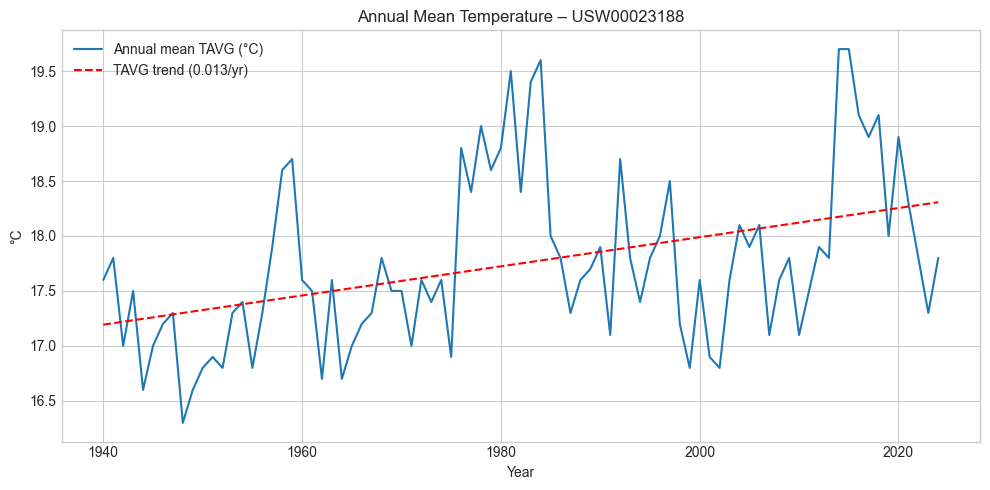

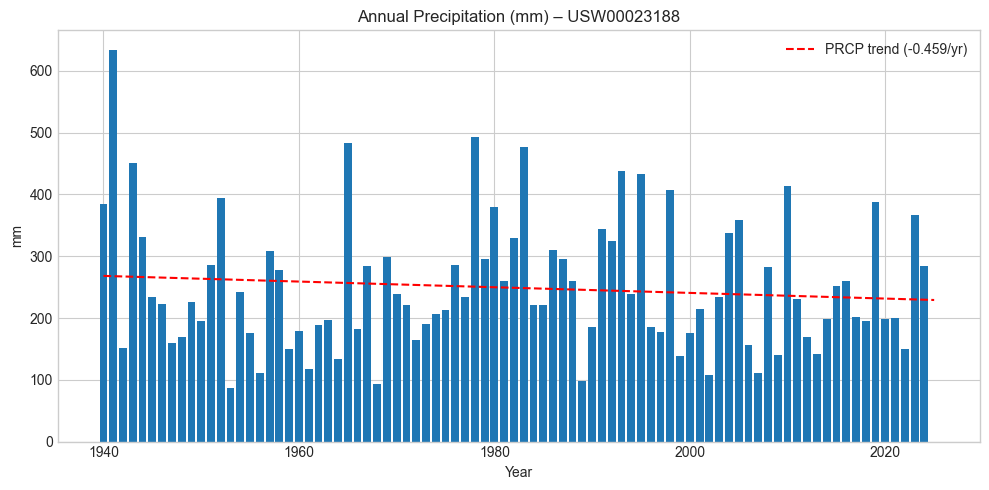

       TAVG_mean    PRCP_sum
count  85.000000   86.000000
mean   17.750588  248.708140
std     0.790814  110.133215
min    16.300000    0.000000
25%    17.200000  176.350000
50%    17.600000  223.950000
75%    18.100000  306.125000
max    19.700000  633.900000


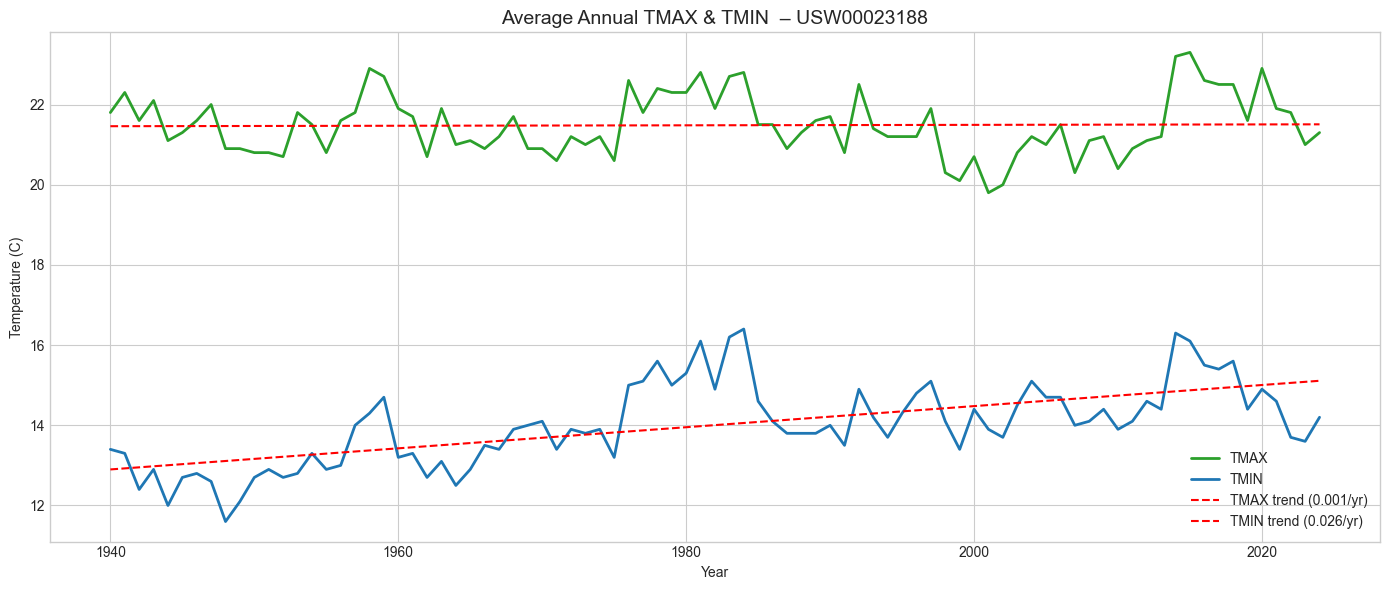

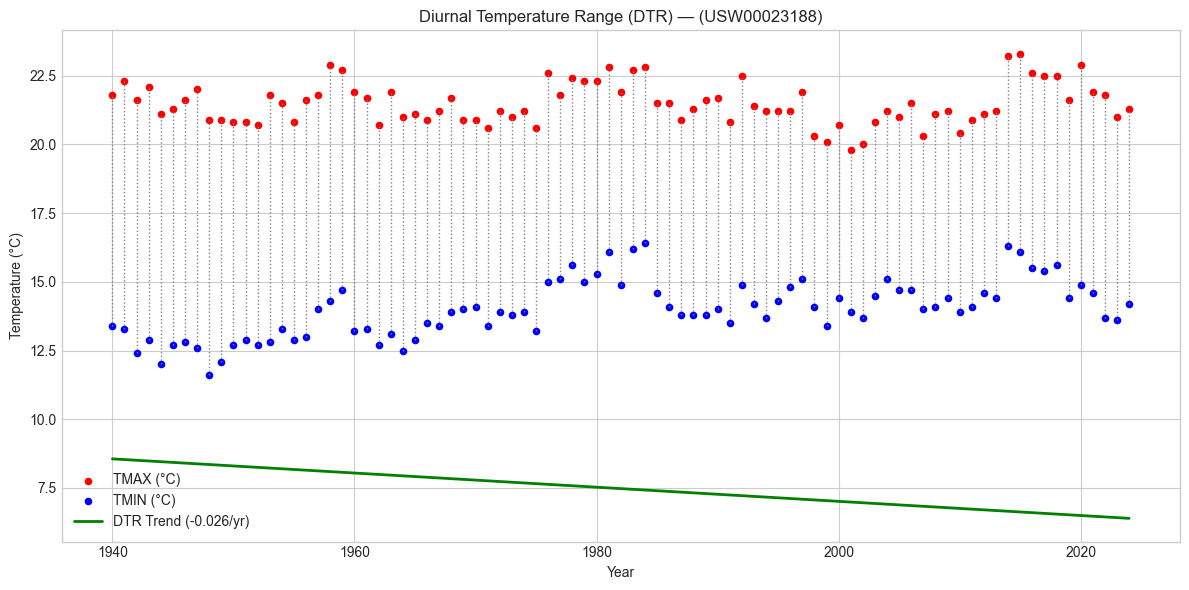

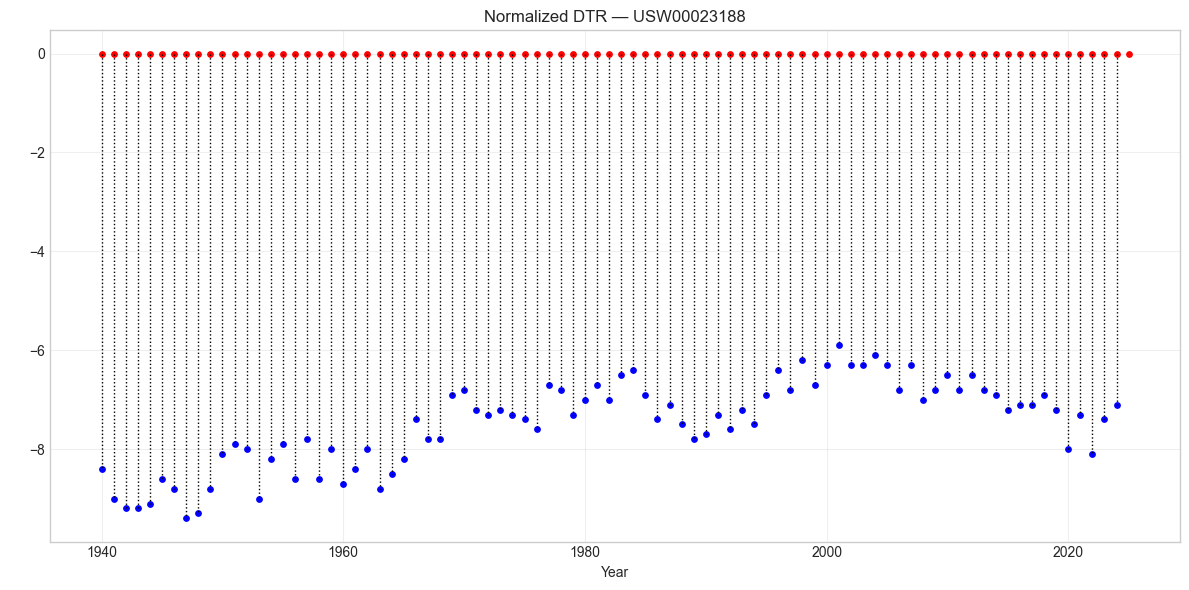

In [91]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
FIG_DIR = Path("figures")
OUTPUT_DIR = Path("output")
FIG_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

# -----------------------------
# Auto-search for data file
# -----------------------------
def find_data_file(filename="data.csv", root=Path(".")):
    """Search for the data file in common subfolders under the project root."""
    search_dirs = [
        root,
        root / "data",
        root / "datasets",
        root / "notebooks",
        root / "notebooks" / "data"
    ]
    for d in search_dirs:
        candidate = d / filename
        if candidate.exists():
            print(f"Found data file at: {candidate}")
            return candidate
    raise FileNotFoundError(f"Could not find {filename} under {root}")

DATA_PATH = find_data_file("data.csv")
print(f"Using data file: {DATA_PATH}")

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv(DATA_PATH)

# -----------------------------
# Ensure STATION column exists
# -----------------------------
if "STATION" not in df.columns:
    df["STATION"] = "SAN DIEGO INTERNATIONAL AIRPORT (USW00023188)"

# -----------------------------
# Date parts
# -----------------------------
df["YEAR"] = pd.to_numeric(df["DATE"], errors="coerce")
df = df[df["YEAR"].notna()]
df["MONTH"] = 1  # dataset is annual, but keep MONTH for consistency

# -----------------------------
# Aggregations with STATION included
# -----------------------------
annual = df.groupby(["YEAR", "STATION"]).agg(
    TAVG_mean=("TAVG", "mean"),
    PRCP_sum=("PRCP", "sum")
).reset_index().rename(columns={"YEAR": "YEAR_", "STATION": "STATION_"})

# -----------------------------
# Pick primary station
# -----------------------------
primary_station = df["STATION"].value_counts().idxmax()
print("Primary station:", primary_station)

ann_primary = annual[annual["STATION_"] == primary_station].copy()

# -----------------------------
# Helper: add regression trend line
# -----------------------------
def add_trend_line(ax, x, y, label):
    mask = (~pd.isna(x)) & (~pd.isna(y))
    X = x[mask].values.reshape(-1, 1)
    Y = y[mask].values
    if len(X) >= 5:
        model = LinearRegression().fit(X, Y)
        slope = model.coef_[0]
        intercept = model.intercept_
        y_fit = intercept + slope * X.flatten()
        ax.plot(X.flatten(), y_fit, color="red", linestyle="--",
                label=f"{label} trend ({slope:.3f}/yr)")
        return slope
    return None

# -----------------------------
# Annual temperature trend
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ann_primary["YEAR_"], ann_primary["TAVG_mean"], label="Annual mean TAVG (°C)")
add_trend_line(ax, ann_primary["YEAR_"], ann_primary["TAVG_mean"], "TAVG")
ax.set_title(f"Annual Mean Temperature – {primary_station}")
ax.set_xlabel("Year"); ax.set_ylabel("°C")
ax.legend()
fig.tight_layout(); fig.savefig(FIG_DIR / "annual_temperature_trend.png")
plt.show()

# -----------------------------
# Annual precipitation totals
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(ann_primary["YEAR_"], ann_primary["PRCP_sum"], color="#1f77b4")
add_trend_line(ax, ann_primary["YEAR_"], ann_primary["PRCP_sum"], "PRCP")
ax.set_title(f"Annual Precipitation (mm) – {primary_station}")
ax.set_xlabel("Year"); ax.set_ylabel("mm")
ax.legend()
fig.tight_layout(); fig.savefig(FIG_DIR / "annual_precipitation.png")
plt.show()

# -----------------------------
# Descriptive stats
# -----------------------------
desc = ann_primary[["TAVG_mean", "PRCP_sum"]].describe()
print(desc)
desc.to_csv(OUTPUT_DIR / "descriptive_stats.csv")

# -----------------------------
# TMAX and TMIN annual plots
# -----------------------------

annual_temps = df.groupby(["YEAR", "STATION"]).agg(
    TMAX_mean=("TMAX", "mean"),
    TMIN_mean=("TMIN", "mean")
).reset_index().rename(columns={"YEAR": "YEAR_", "STATION": "STATION_"})

ann_primary_temps = annual_temps[annual_temps["STATION_"] == primary_station].copy()

y_min = min(ann_primary_temps["TMIN_mean"].min(), ann_primary_temps["TMAX_mean"].min())
y_max = max(ann_primary_temps["TMIN_mean"].max(), ann_primary_temps["TMAX_mean"].max())

y_pad = 0.5
y_limits = (y_min - y_pad, y_max + y_pad)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    ann_primary_temps["YEAR_"],
    ann_primary_temps["TMAX_mean"],
    label="TMAX",
    color="tab:green",
    linewidth=2
)

ax.plot(
    ann_primary_temps["YEAR_"],
    ann_primary_temps["TMIN_mean"],
    label="TMIN",
    color="tab:blue",
    linewidth=2
)

add_trend_line(
    ax,
    ann_primary_temps["YEAR_"],
    ann_primary_temps["TMAX_mean"],
    "TMAX"
)

add_trend_line(
    ax,
    ann_primary_temps["YEAR_"],
    ann_primary_temps["TMIN_mean"],
    "TMIN"
)

ax.set_ylim(y_limits)
ax.set_title(f"Average Annual TMAX & TMIN  – {primary_station}", fontsize=14)
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (C)")
ax.legend()
fig.tight_layout()
fig.savefig(FIG_DIR / "annual_tmax_tmin.png")
plt.show()


# ---------------------
# DTR visualization
# ---------------------

df["TMAX"] = pd.to_numeric(df["TMAX"], errors="coerce")
df["TMIN"] = pd.to_numeric(df["TMIN"], errors="coerce")
df["YEAR"] = pd.to_numeric(df["YEAR"], errors="coerce")

dtr_df = df.dropna(subset=["YEAR", "TMAX", "TMIN"]).copy()
dtr_df["DTR"] = dtr_df["TMAX"] - dtr_df["TMIN"]
fig, ax = plt.subplots(figsize=(12, 6))

years = dtr_df["YEAR"].values
tmax_values = dtr_df["TMAX"].values
tmin_values = dtr_df["TMIN"].values
dtr_values = dtr_df["DTR"].values

ax.scatter(years, tmax_values, color="red", label="TMAX (°C)", s=20)
ax.scatter(years, tmin_values, color="blue", label="TMIN (°C)", s=20)

for x, tmax, tmin in zip(years, tmax_values, tmin_values):
    ax.plot([x, x], [tmin, tmax], color="gray", linestyle=":", linewidth=1)

mask = ~np.isnan(years) & ~np.isnan(dtr_values)
X = years[mask].reshape(-1, 1)
Y = dtr_values[mask]

model = LinearRegression().fit(X, Y)
slope = model.coef_[0]
intercept = model.intercept_

trend_line = intercept + slope * years

ax.plot(years, trend_line, color="green", linewidth=2,
        label=f"DTR Trend ({slope:.3f}/yr)")
ax.set_title("Diurnal Temperature Range (DTR) — (USW00023188)")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.legend()
fig.tight_layout()
plt.show()

fig.savefig(FIG_DIR / "DTR_trend.png")

# -----------------------------
# Normalized DTR visualization
# -----------------------------

df["DTR"] = df["TMAX"] - df["TMIN"]
fig, ax = plt.subplots(figsize=(12, 6))
baseline = 0

years = df["YEAR"]
dtrs = df["DTR"]

for year, dtr in zip(years, dtrs):
    ax.plot([year, year], [baseline, baseline - dtr], 
            color="black", linestyle=":", linewidth=1)

ax.scatter(years, np.zeros_like(years), 
           color="red", s=15)
ax.scatter(years, -dtrs, 
           color="blue", s=15)

ax.set_title("Normalized DTR — USW00023188")
ax.set_xlabel("Year")
ax.set_ylabel(" ")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Mean precipitation: 248.71 mm


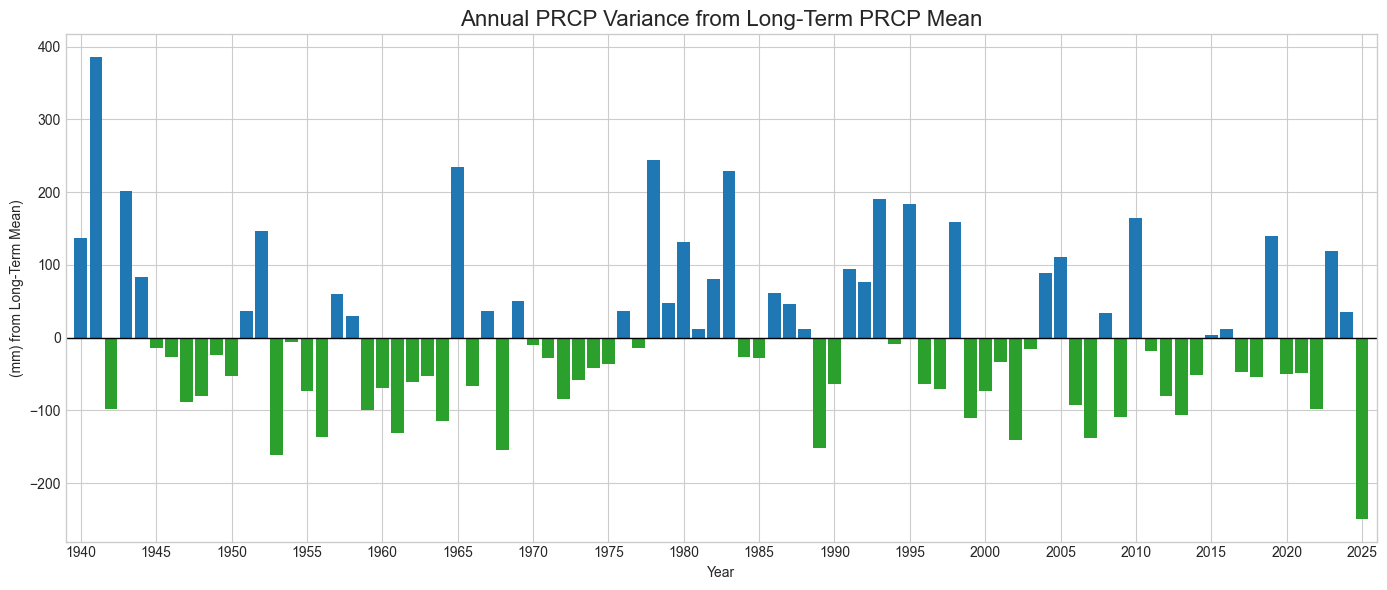

In [92]:
# -----------------------
# Precipitation anomaly
# -----------------------

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")


df_pr = ann_primary.copy()
df_pr = df_pr.rename(columns={"YEAR_": "YEAR", "PRCP_sum": "PRCP"})

df_pr["PRCP"] = pd.to_numeric(df_pr["PRCP"], errors="coerce")
df_pr = df_pr.dropna(subset=["PRCP"])

long_term_mean = df_pr["PRCP"].mean()
df_pr["ANOMALY"] = df_pr["PRCP"] - long_term_mean

print(f"Mean precipitation: {long_term_mean:.2f} mm")

fig, ax = plt.subplots(figsize=(14, 6))

colors = df_pr["ANOMALY"].apply(lambda x: "tab:blue" if x >= 0 else "tab:green")
ax.bar(df_pr["YEAR"], df_pr["ANOMALY"], color=colors, width=0.85)

ax.axhline(0, color="black", linewidth=1)
ax.set_title("Annual PRCP Variance from Long-Term PRCP Mean" , fontsize=16)
ax.set_xlabel("Year")
ax.set_ylabel("(mm) from Long-Term Mean)")
ax.set_xticks(range(int(df_pr["YEAR"].min()), int(df_pr["YEAR"].max()) + 1, 5))
ax.set_xlim(df_pr["YEAR"].min() - 1, df_pr["YEAR"].max() + 1)
plt.tight_layout()

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)
out_path = FIG_DIR / "prcp_anomaly_plot.png"
plt.savefig(out_path, dpi=200)
plt.show()


Loading data from: output\USW00023188.csv
Rows in file: 31,560
Saved per-day extremes to: output\extreme_days_year_month_tmax.csv
   YEAR  NUM_EXTREME_HOT_DAYS
0  1940                     6
1  1941                     1
2  1942                     2
3  1943                     0
4  1944                     0
Saved per-day extremes to: output\extreme_days_year_month_tmax.csv
   YEAR  NUM_EXTREME_HOT_DAYS
0  1940                     6
1  1941                     1
2  1942                     2
3  1943                     0
4  1944                     0


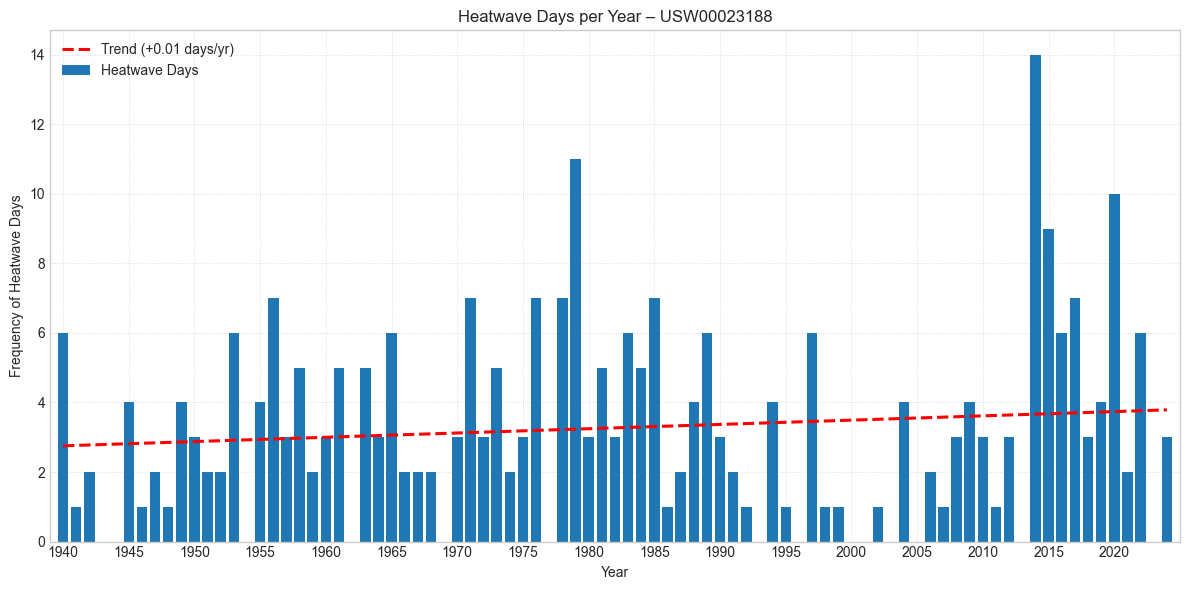

,YEAR,MONTH,TMAX_C
0,1940,4,32.2
1,1940,4,32.8
2,1940,4,35.0
3,1940,9,33.9
4,1940,10,32.8
...,...,...,...
273,2022,9,34.4
274,2022,10,35.0
275,2024,9,32.2
276,2024,9,34.4


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression

# -------------------------
# Heatwave days trend
# -------------------------

candidates = [
    Path('output') / 'USW00023188.csv',
    Path('outputs') / 'USW00023188.csv',
    Path('USW00023188.csv')
]
for p in candidates:
    if p.exists():
        data_path = p
        break
else:
    raise FileNotFoundError('Could not find USW00023188.csv in expected locations')

print(f'Loading data from: {data_path}')

df_raw = pd.read_csv(data_path)
print(f'Rows in file: {len(df_raw):,}')

# If file contains multiple stations, filter to San Diego airport
if 'STATION' in df_raw.columns:
    df = df_raw[df_raw['STATION'].astype(str)
                .str.contains('USW00023188|SAN DIEGO', case=False, na=False)].copy()
    if df.empty:
        df = df_raw.copy()
else:
    df = df_raw.copy()

# Parse DATE column (NOAA daily format is usually YYYYMMDD)
if 'DATE' not in df.columns:
    raise KeyError('DATE column not found in CSV')

df['DATE_dt'] = pd.to_datetime(df['DATE'].astype(str),
                               format='%Y%m%d',
                               errors='coerce')
if df['DATE_dt'].isna().any():
    df.loc[df['DATE_dt'].isna(), 'DATE_dt'] = pd.to_datetime(
        df.loc[df['DATE_dt'].isna(), 'DATE'],
        errors='coerce'
    )

n_bad = df['DATE_dt'].isna().sum()
if n_bad:
    print(f'Warning: {n_bad} rows have unparseable dates and will be ignored')

df = df[df['DATE_dt'].notna()].copy()

# Year / month subset (1940–2024)
df['YEAR'] = df['DATE_dt'].dt.year.astype(int)
df['MONTH'] = df['DATE_dt'].dt.month.astype(int)
start_year, end_year = 1940, 2024
df = df[(df['YEAR'] >= start_year) & (df['YEAR'] <= end_year)].copy()

# Temperature in °C
if 'TMAX' not in df.columns:
    raise KeyError('TMAX column missing from CSV')

df['TMAX_raw'] = pd.to_numeric(df['TMAX'], errors='coerce')
df['TMAX_C'] = df['TMAX_raw'] / 10.0

# -----------------------------------------
# Build per-day extreme hot days dataframe
# -----------------------------------------
threshold_c = 32.0
extreme_days_df = df.loc[df['TMAX_C'] >= threshold_c,
                         ['YEAR', 'MONTH', 'TMAX_C']].copy()
extreme_days_df = extreme_days_df.reset_index(drop=True)

# Save ONLY the per-day extremes table
out_dir = Path('output')
out_dir.mkdir(parents=True, exist_ok=True)
extreme_path = out_dir / 'extreme_days_year_month_tmax.csv'
extreme_days_df.to_csv(extreme_path, index=False)
print('Saved per-day extremes to:', extreme_path)

# -----------------------------------------
# Derive annual counts for plotting only
# -----------------------------------------
annual = extreme_days_df.groupby('YEAR').size().reset_index(
    name='NUM_EXTREME_HOT_DAYS'
)

# Ensure all years 1940–2024 are present (fill missing with 0)
all_years = pd.DataFrame({'YEAR': list(range(start_year, end_year + 1))})
annual = all_years.merge(annual, on='YEAR', how='left').fillna(0)
annual['NUM_EXTREME_HOT_DAYS'] = annual['NUM_EXTREME_HOT_DAYS'].astype(int)

result_df = annual[['YEAR', 'NUM_EXTREME_HOT_DAYS']].copy()
print(result_df.head())

# -----------------------------------------
# Plot heatwave days per year (no extra CSV)
# -----------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    result_df['YEAR'],
    result_df['NUM_EXTREME_HOT_DAYS'],
    color='tab:blue',
    width=0.8,
    label='Heatwave Days'
)

X = result_df['YEAR'].values.reshape(-1, 1)
y = result_df['NUM_EXTREME_HOT_DAYS'].values
model = LinearRegression().fit(X, y)
slope = float(model.coef_[0])
y_trend = model.predict(X)

ax.plot(
    result_df['YEAR'],
    y_trend,
    color='red',
    linestyle='--',
    linewidth=2.2,
    label=f'Trend ({slope:+.2f} days/yr)'
)

ax.set_xlabel('Year')
ax.set_ylabel('Frequency of Heatwave Days')
ax.set_title('Heatwave Days per Year – USW00023188')
ax.set_xlim(start_year - 1, end_year + 1)
ax.set_xticks(list(range(start_year, end_year + 1, 5)))
ax.legend(loc='upper left')
ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.8)
plt.tight_layout()

fig_dir = Path('figures')
fig_dir.mkdir(parents=True, exist_ok=True)
out_path = fig_dir / 'extreme_temp_days.png'
fig.savefig(out_path, dpi=200)
print(f'Saved figure to: {out_path}')

plt.show()

# Return per-day extremes table (YEAR, MONTH, TMAX_C)
extreme_days_df


Temperature trend (°C/year): {'slope_per_year': np.float64(0.013255813953488377), 'intercept': np.float64(-8.522435020519847), 'r2': 0.17115925643643348}
Precipitation trend (mm/year): {'slope_per_year': np.float64(-0.4591112788339072), 'intercept': np.float64(1158.8962498231047), 'r2': 0.010835170490503199}


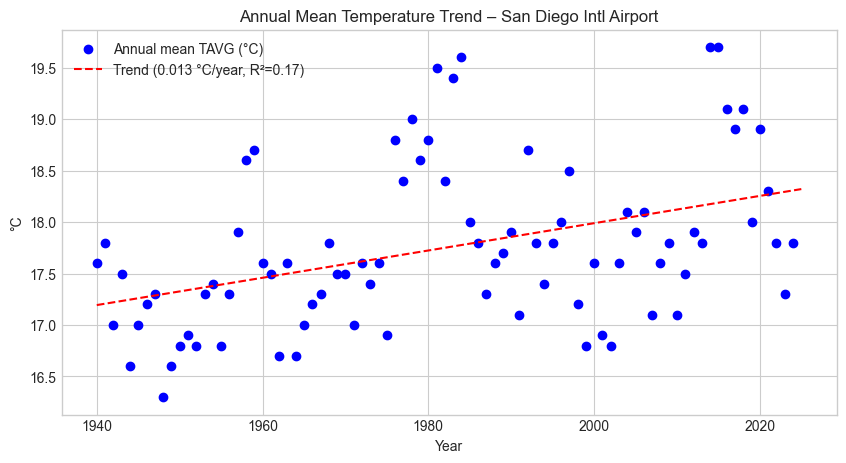

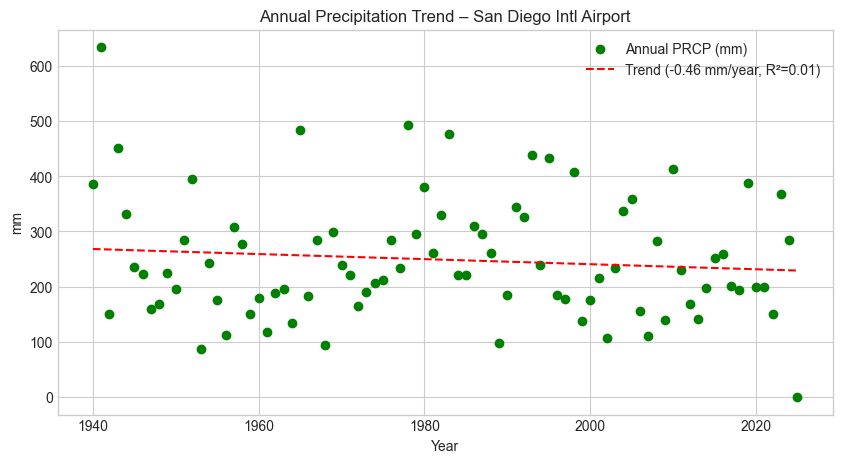

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -----------------------------
# Load data
# -----------------------------

df = pd.read_csv("data.csv")

# -----------------------------
# Ensure YEAR column
# -----------------------------

df["YEAR"] = pd.to_numeric(df["DATE"], errors="coerce")

# -----------------------------
# Aggregate to annual values
# -----------------------------

ann_primary = (
    df.groupby("YEAR")
      .agg(TAVG_mean=("TAVG", "mean"),
           PRCP_sum=("PRCP", "sum"))
      .reset_index()
)

# -----------------------------
# Helper: linear regression trend
# -----------------------------

def linear_trend(x_years, y_values):
    mask = (~pd.isna(x_years)) & (~pd.isna(y_values))
    X = x_years[mask].values.reshape(-1, 1)
    y = y_values[mask].values
    if len(X) < 5:
        return None
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)
    return {"slope_per_year": slope, "intercept": intercept, "r2": r2}

# Compute trends

temp_trend = linear_trend(ann_primary["YEAR"], ann_primary["TAVG_mean"])
prcp_trend = linear_trend(ann_primary["YEAR"], ann_primary["PRCP_sum"])

print("Temperature trend (°C/year):", temp_trend)
print("Precipitation trend (mm/year):", prcp_trend)

# -----------------------------
# Temperature trend plot
# -----------------------------

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(ann_primary["YEAR"], ann_primary["TAVG_mean"],
           label="Annual mean TAVG (°C)", color="blue")

if temp_trend:
    years = np.array(ann_primary["YEAR"])
    y_fit = temp_trend["intercept"] + temp_trend["slope_per_year"] * years
    ax.plot(years, y_fit, color="red", linestyle="--",
            label=f"Trend ({temp_trend['slope_per_year']:.3f} °C/year, R²={temp_trend['r2']:.2f})")

ax.set_title("Annual Mean Temperature Trend – San Diego Intl Airport")
ax.set_xlabel("Year")
ax.set_ylabel("°C")
ax.legend()
ax.grid(True)
plt.show()

# -----------------------------
# Precipitation trend plot
# -----------------------------

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(ann_primary["YEAR"], ann_primary["PRCP_sum"],
           label="Annual PRCP (mm)", color="green")

if prcp_trend:
    years = np.array(ann_primary["YEAR"])
    y_fit = prcp_trend["intercept"] + prcp_trend["slope_per_year"] * years
    ax.plot(years, y_fit, color="red", linestyle="--",
            label=f"Trend ({prcp_trend['slope_per_year']:.2f} mm/year, R²={prcp_trend['r2']:.2f})")

ax.set_title("Annual Precipitation Trend – San Diego Intl Airport")
ax.set_xlabel("Year")
ax.set_ylabel("mm")
ax.legend()
ax.grid(True)
plt.show()